# Exploring XGboost Tree Structure

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

This dataset comes from the following kaggle competition:
https://www.kaggle.com/c/home-credit-default-risk  
The `target` field we will be predicting is if a person will default on their housing loan, or not.

In [2]:
df_full = pd.read_parquet("data/application_train_proc.parquet")

I have already done some prep work to the data, creating encoded object fields, and removing a few records. I could would definitely do more feature engineering if I was looking to maximize performance, but for now we are just using this dataset as a way to test feature reduction.

In [3]:
df_full.shape

(307507, 136)

In [4]:
df_full.dtypes.value_counts()

float64    70
int64      41
object     16
int8        9
dtype: int64

Drop `object` columns and convert data to `np.float32` to keeps things consistent for XGBoost modeling.

In [5]:
drop_cols = df_full.dtypes.pipe(lambda x: x[x.eq("object")]).index
df = df_full.drop(columns=drop_cols)
# For now we will just start off testing with a sample of the data to speed things up.
df = df.sample(70_000, random_state=123)

In [6]:
df.shape

(70000, 120)

We are going to split our data into a development, testing, and then hold out validation sample.

In [7]:
np.random.seed(123)
rand_num = np.random.uniform(size=df.shape[0])
dev = rand_num < 0.5
val = (0.5 <= rand_num) & (rand_num < 0.75)
tst = 0.75 <= rand_num

In [8]:
X = df.drop(columns=["target"]).astype(np.float32)
y = df["target"].astype(np.float32)

We we create out `xgboost.DMatrix` objects, these are the data types that are required to use the XGBoost Learning API.

In [9]:
xdev = xgb.DMatrix(X[dev], label=y[dev], missing=np.nan)
xtst = xgb.DMatrix(X[tst], label=y[tst], missing=np.nan)
xval = xgb.DMatrix(X[val], label=y[val], missing=np.nan)

### Training a Baseline Model Optimized with `scikit-optimize`
First we will train a baseline model, and we will use bayesian optimization through the `scikit-optimize` package with the `gp_minimize` function.  
The following will be our "base" set of parameters.  
```python
params = dict(
    objective="binary:logitraw",
    eta=0.1,
    max_depth=0,
    min_child_weight=50,
    max_leaves=35,
    tree_method="hist",
    grow_policy="lossguide",
    subsample=0.8,
    colsample_bytree=0.50,
    eval_metric="auc",
    seed=0,
)
```
We will optimize the following XGBoost parameters.  
- `eta`
- `min_child_weight`
- `max_leaves`
- `subsample`
- `colsample_bytree`

In [10]:
unopt_params = dict(
    objective="binary:logitraw",
    eta=0.1,
    max_depth=0,
    min_child_weight=50,
    max_leaves=35,
    tree_method="hist",
    grow_policy="lossguide",
    subsample=0.8,
    colsample_bytree=0.50,
    eval_metric="auc",
    seed=0,
)

In [11]:
unopt_watchlist = [(xdev, "dev"), (xtst, "test")]

In [12]:
unopt_mod = xgb.train(
    params=unopt_params,
    dtrain=xdev,
    num_boost_round=1_000,
    early_stopping_rounds=50,
    evals=unopt_watchlist,
    verbose_eval=100,
)

[0]	dev-auc:0.70681	test-auc:0.66866
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[100]	dev-auc:0.85891	test-auc:0.73750
Stopping. Best iteration:
[81]	dev-auc:0.84565	test-auc:0.73811



In [13]:
xgb_search_space = [
    Real(0.05, 0.2, name="eta"),
    Integer(50, 200, name="min_child_weight"),
    Integer(15, 35, name="max_leaves"),
    Real(0.5, 1.0, name="subsample"),
    Real(0.5, 1.0, name="colsample_bytree"),
]

Next we have to set up the function we want to minimize, in our case, it will be the cross validation performance of the model on our development dataset.

In [20]:
# These are our constant parameters, that will remain unchanged through
# all of modeling.
base_params = dict(
    objective="binary:logitraw",
    max_depth=0,
    tree_method="hist",
    grow_policy="lossguide",
    eval_metric="auc",
    seed=123,
)

watchlist = [(xdev, "dev"), (xtst, "test")]

# These are our constant parameters, that will remain unchanged through
# all of modeling.
base_params = dict(
    objective="binary:logitraw",
    max_depth=0,
    tree_method="hist",
    grow_policy="lossguide",
    eval_metric="auc",
    seed=0,
)


@use_named_args(xgb_search_space)
def xgb_obj_func(**points):
    mod_points = {**points, **base_params}
    bayes_mod = xgb.train(
        params=mod_points,
        dtrain=xdev,
        num_boost_round=1_000,
        early_stopping_rounds=50,
        evals=watchlist,
        verbose_eval=False,
    )
    print(f"score: {bayes_mod.best_score:.4f}, iterations: {bayes_mod.best_iteration}")
    return -bayes_mod.best_score

We optimize our objective function using the `gp_minimize` function from scikit-optimize.

In [21]:
bayes_params = gp_minimize(
    xgb_obj_func,
    xgb_search_space,
    n_calls=35,
    # Our initial points.
    # [eta=0.1, min_child_weight=50, max_leaves=35, subsample=0.8, colsample_bytree=0.50,]
    x0=[0.1, 50, 35, 0.8, 0.50,],
    random_state=0,
)

score: 0.7381, iterations: 81
score: 0.7407, iterations: 127
score: 0.7397, iterations: 157
score: 0.7387, iterations: 78
score: 0.7405, iterations: 113
score: 0.7426, iterations: 203
score: 0.7371, iterations: 161
score: 0.7410, iterations: 201
score: 0.7410, iterations: 123
score: 0.7404, iterations: 108
score: 0.7429, iterations: 174
score: 0.7406, iterations: 80
score: 0.7416, iterations: 341
score: 0.7425, iterations: 188
score: 0.7423, iterations: 234
score: 0.7426, iterations: 213
score: 0.7357, iterations: 32
score: 0.7408, iterations: 253
score: 0.7429, iterations: 81
score: 0.7393, iterations: 80
score: 0.7421, iterations: 515
score: 0.7438, iterations: 475
score: 0.7399, iterations: 177
score: 0.7418, iterations: 664
score: 0.7414, iterations: 98
score: 0.7367, iterations: 31
score: 0.7426, iterations: 155
score: 0.7422, iterations: 127
score: 0.7413, iterations: 98
score: 0.7415, iterations: 167
score: 0.7414, iterations: 81
score: 0.7435, iterations: 324
score: 0.7420, ite

Now we will take the best parameters from this optimization and train a model.

In [22]:
best_bayes_params = np.argmin(bayes_params.func_vals)
best_bayes_params = {
    s.name: p for s, p in zip(xgb_search_space, bayes_params.x_iters[best_bayes_params])
}
np.argmin(bayes_params.func_vals)

21

In [23]:
best_bayes_params = {**base_params, **best_bayes_params}
best_bayes_params

{'objective': 'binary:logitraw',
 'max_depth': 0,
 'tree_method': 'hist',
 'grow_policy': 'lossguide',
 'eval_metric': 'auc',
 'seed': 0,
 'eta': 0.05,
 'min_child_weight': 200,
 'max_leaves': 15,
 'subsample': 0.9089253160514756,
 'colsample_bytree': 0.5191388857129513}

In [24]:
base_mod = xgb.train(
    params=best_bayes_params,
    dtrain=xdev,
    num_boost_round=1_000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=100,
)

[0]	dev-auc:0.69358	test-auc:0.67314
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[100]	dev-auc:0.77341	test-auc:0.73544
[200]	dev-auc:0.78720	test-auc:0.74021
[300]	dev-auc:0.79837	test-auc:0.74222
[400]	dev-auc:0.80698	test-auc:0.74320
[500]	dev-auc:0.81431	test-auc:0.74334
Stopping. Best iteration:
[475]	dev-auc:0.81266	test-auc:0.74377



In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

tt = sns.load_dataset("titanic").select_dtypes("number")
X, y = tt.drop(columns="survived"), tt["survived"]

mono = np.sign(X.apply(lambda x: x.corr(y))).to_dict()

xcl = xgb.sklearn.XGBClassifier(
    objective="binary:logitraw",
    n_estimators=30,
    monotone_constraints=str(tuple([int(mono.get(col)) for col in X.columns])),
)
xcl.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(-1, -1, -1, 1, 1)', n_estimators=30,
              n_jobs=0, num_parallel_tree=1, objective='binary:logitraw',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [2]:
mod_dmp = [json.loads(d) for d in xcl.get_booster().get_dump(dump_format="json")]

In [3]:
def missing_value(value, missing):
    return (value == missing) | (np.isnan(value) & np.isnan(missing))


def tree_climber(tree, row_dict, missing=np.nan):
    if "leaf" in tree:
        return np.float32(tree["leaf"])
    else:
        value = row_dict.get(tree["split"])
        if missing_value(value, missing):
            nodeid = tree["missing"]
        elif value < tree["split_condition"]:
            nodeid = tree["yes"]
        else:
            nodeid = tree["no"]
        which_child = np.argmax([chld["nodeid"] == nodeid for chld in tree["children"]])
        return tree_climber(tree["children"][which_child], row_dict, missing)

In [4]:
len(mod_dmp)

30

In [5]:
tree_climber(mod_dmp[0], X.iloc[0, :])

-0.3286488

In [6]:
def row_predict(dump_list, row, missing=np.nan):
    pred = np.float32(0.0)
    for d in dump_list:
        pred += tree_climber(d, row, missing=np.nan)
    return pred

In [7]:
def recursive_predict(model, data, missing=np.nan):
    model_dump = [json.loads(d) for d in model.get_dump(dump_format="json")]
    preds = []
    for i, row in data.iterrows():
        preds.append(row_predict(model_dump, row, missing))
    return np.array(preds)

In [8]:
xcl.predict_proba(X.iloc[0:5, :])

array([[ 2.486742  , -1.4867419 ],
       [-0.11968648,  1.1196865 ],
       [ 2.2820241 , -1.2820241 ],
       [-0.07544243,  1.0754424 ],
       [ 2.843956  , -1.8439561 ]], dtype=float32)

In [9]:
recursive_predict(xcl.get_booster(), X.iloc[0:5, :])

array([-1.4867419,  1.1196865, -1.2820241,  1.0754424, -1.8439561],
      dtype=float32)

In [10]:
r_preds = recursive_predict(xcl.get_booster(), X)
m_preds = xcl.predict_proba(X)[:, 1]

In [11]:
all(r_preds == m_preds)

True

In [12]:
def pdp_brute(model, data, feature):
    res = {}
    for value in np.sort(data[feature].unique()):
        if np.isnan(value):
            continue
        md = data.copy()
        md[feature] = value
        p = model.predict_proba(md)[:, 1]
        res[value] = np.mean(p)
    return pd.Series(res, name=feature)

<AxesSubplot:>

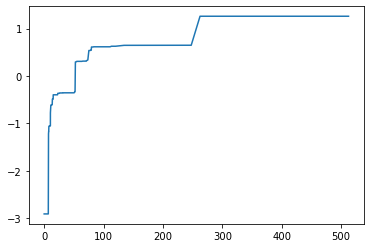

In [13]:
pdp_brute(xcl, X, "fare").plot.line()

<AxesSubplot:>

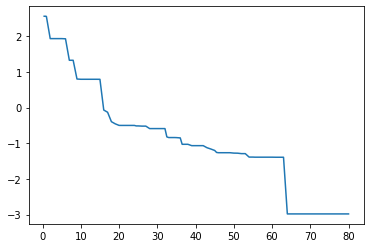

In [14]:
pdp_brute(xcl, X, "age").plot.line()

In [15]:
mono

{'pclass': -1.0, 'age': -1.0, 'sibsp': -1.0, 'parch': 1.0, 'fare': 1.0}

In [16]:
mod_dmp = [
    json.loads(d)
    for d in xcl.get_booster().get_dump(dump_format="json", with_stats=True)
]

To calculate the "fast" recursive version of the pdp plots, we need to know the number of observations in each node... I am not positive how to calculate this with Cover... So we will update our manual predict function to calculate this for us, and compare to cover to understand the number of obs visiting each node.

In [17]:
# Retrain model to be small
mono = np.sign(X.apply(lambda x: x.corr(y))).to_dict()

tt = sns.load_dataset("titanic").select_dtypes("number")
X, y = tt.drop(columns="survived"), tt["survived"]
xcl = xgb.sklearn.XGBClassifier(
    objective="binary:logitraw",
    n_estimators=1,
    max_depth=3,
    monotone_constraints=str(tuple([int(mono.get(col)) for col in X.columns])),
)
xcl.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan,
              monotone_constraints='(-1, -1, -1, 1, 1)', n_estimators=1,
              n_jobs=0, num_parallel_tree=1, objective='binary:logitraw',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [18]:
def tree_climber_with_stats(tree, row_dict, missing=np.nan):
    if "leaf" in tree:
        return np.float32(tree["leaf"])
    else:
        value = row_dict.get(tree["split"])
        if missing_value(value, missing):
            nodeid = tree["missing"]
        elif value < tree["split_condition"]:
            nodeid = tree["yes"]
        else:
            nodeid = tree["no"]

        if node_dict.get(nodeid) is None:
            node_dict[nodeid] = 1
        else:
            node_dict[nodeid] += 1

        which_child = np.argmax([chld["nodeid"] == nodeid for chld in tree["children"]])
        return tree_climber_with_stats(tree["children"][which_child], row_dict, missing)

In [19]:
def row_predict_with_stats(dump_list, row, missing=np.nan):
    pred = np.float32(0.0)
    for d in dump_list:
        pred += tree_climber_with_stats(d, row, missing=np.nan)
    return pred

In [20]:
def recursive_predict_with_stats(model_dump, data, missing=np.nan):
    # model_dump = [json.loads(d) for d in model.get_dump(dump_format="json")]
    preds = []
    for i, row in data.iterrows():
        preds.append(row_predict_with_stats(model_dump, row, missing))
    return np.array(preds)

In [21]:
def get_stat(node, key, stat_dict):
    stat_dict[node["nodeid"]] = node[key]
    if "leaf" in node:
        return
    else:
        for child in node["children"]:
            get_stat(child, key, stat_dict)

In [91]:
891 * ((1 - 0.5) * 0.5)

222.75

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

tt = sns.load_dataset("titanic").select_dtypes("number")
X, y = tt.drop(columns="survived"), tt["survived"]

mono = np.sign(X.apply(lambda x: x.corr(y))).to_dict()

# xcl = xgb.sklearn.XGBClassifier(
#     objective="binary:logitraw",
#     n_estimators=30,
#     monotone_constraints=str(tuple([int(mono.get(col)) for col in X.columns])),
# )
# xcl.fit(X, y)

In [2]:
def pdp_brute(model, data, feature):
    res = {}
    for value in np.sort(data[feature].unique()):
        if np.isnan(value):
            continue
        md = data.copy()
        md[feature] = value
        p = model.predict_proba(md)[:, 1]
        res[value] = np.mean(p)
    return pd.Series(res, name=feature)

In [95]:
class PartialDependence:
    def __init__(self, model, base_pred=0.0, missing=np.nan):
        self.p_dep = 0
        self.base_pred = base_pred
        self.tree_pred = 0.5
        self.n_leaves = 0
        self.missing = missing
        self.model = model

    @staticmethod
    def missing_value(value, missing):
        return (value == missing) | (np.isnan(value) & np.isnan(missing))

    def get_samples(self, cover):
        # Adjusting cover is almost meaningless because we normalize it
        # by dividing it by the parent nodes value.
        return cover  # cover / ((1 - self.tree_pred) * self.tree_pred)

    def tree_pdp(self, node, feature, value, prop):
        if "leaf" in node:
            self.n_leaves += 1
            self.p_dep += prop * node["leaf"]
            return

        elif node["split"] == feature:
            if self.missing_value(value, self.missing):
                nodeid = node["missing"]
            elif value < node["split_condition"]:
                nodeid = node["yes"]
            else:
                nodeid = node["no"]

            child = [chld for chld in node["children"] if chld["nodeid"] == nodeid][0]
            self.tree_pdp(child, feature, value, prop)
        else:
            l_s = node["children"][0]["cover"]
            r_s = node["children"][1]["cover"]
            t_s = l_s + r_s

            self.tree_pdp(node["children"][0], feature, value, prop * (l_s / t_s))
            self.tree_pdp(node["children"][1], feature, value, prop * (r_s / t_s))

    def calc_pdp(self, feature, points=None): # min_max=(0.0, 513.0), n_pts=20,):
        res = np.empty(0)
        forest = [
            json.loads(d)
            for d in self.model.get_dump(dump_format="json", with_stats=True)
        ]
        # if points is None:
        #     min_, max_ = min_max
        #     points = np.linspace(min_, max_, n_pts)
        # else:
        #     n_pts = len(points)
        for point in points:
            self.p_dep = self.base_pred
            self.n_leaves = 0
            for tree in forest:
                self.tree_pdp(tree, feature, point, 1)
            self.p_dep = self.p_dep # / len(forest)
            res = np.append(res, self.p_dep)
        return np.column_stack((points, res))

In [129]:
# Retrain model to be small
mono = np.sign(X.apply(lambda x: x.corr(y))).to_dict()

tt = sns.load_dataset("titanic").select_dtypes("number")
X, y = tt.drop(columns="survived"), tt["survived"]
# X = pd.concat([X, X, X, X, X, X, X, X, X])
# y = pd.concat([y, y, y, y, y, y, y, y, y])

xcl = xgb.sklearn.XGBClassifier(
    objective="binary:logitraw",
    n_estimators=1_000,
    max_depth=32,
    grow_policy="lossguide",
    monotone_constraints=str(tuple([int(mono.get(col)) for col in X.columns])),
)
xcl.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=32, min_child_weight=1, missing=nan,
              monotone_constraints='(-1, -1, -1, 1, 1)', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='binary:logitraw',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

<AxesSubplot:>

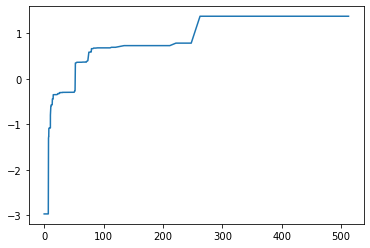

In [130]:
pdep = PartialDependence(xcl.get_booster())
t1 = pdep.calc_pdp(feature="fare", points=np.sort(X["fare"].unique()))
sns.lineplot(x=t1[:, 0], y=t1[:, 1])

<AxesSubplot:>

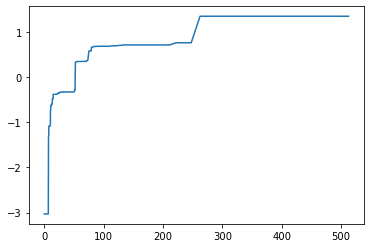

In [131]:
t2 = pdp_brute(xcl, X, "fare")
t2.plot.line()

In [132]:
%%timeit
pdp_brute(xcl, X, "fare")

799 ms ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [133]:
%%timeit
pdep.calc_pdp(feature="fare", points=np.sort(X["fare"].unique()))

681 ms ± 54.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [127]:
t2.min()

-3.697645902633667

In [128]:
t1[:,1].min()

-3.5501779409257557

In [109]:
# pd.DataFrame({"r": t1[:, 1], "b": t2}).assign(r_b=lambda x: x.r / x.b)

In [29]:
pdep.p_dep

0.37935385099999996

In [30]:
mod_dmp[0]["children"][0]["split_condition"]

13.6458502

In [ ]:
p_dep = 0

In [44]:
# Retrain model to be small
mono = np.sign(X.apply(lambda x: x.corr(y))).to_dict()

tt = sns.load_dataset("titanic").select_dtypes("number")
X, y = tt.drop(columns="survived"), tt["survived"]
xcl = xgb.sklearn.XGBClassifier(
    objective="binary:logitraw",
    n_estimators=10,
    max_depth=3,
    monotone_constraints=str(tuple([int(mono.get(col)) for col in X.columns])),
)
xcl.fit(X, y)

mod_dmp = [
    json.loads(d)
    for d in xcl.get_booster().get_dump(dump_format="json", with_stats=True)
]

mod_tree = 9
node_dict = {}
r_preds = recursive_predict_with_stats([mod_dmp[mod_tree]], X)
# m_preds = xcl.predict_proba(X)[:, 1]
# all(r_preds == m_preds)
node_dict[0] = X.shape[0]
npd = pd.Series(node_dict, name="obs").sort_index().to_frame()
node_cover = {}
get_stat(mod_dmp[mod_tree], "cover", node_cover)
npd = pd.concat([npd, pd.Series(node_cover, name="cover")], axis=1)

In [45]:
npd.assign(
    odc=lambda x: x["obs"].div(x["cover"]),
    calc_recs=lambda x: x["cover"].div((1 - 0.5) * 0.5),
)

,obs,cover,odc,calc_recs
0,891,177.904129,5.008315,711.616516
1,878,175.343262,5.007321,701.373048
2,13,2.560869,5.076401,10.243477
3,732,145.340240,5.036458,581.360960
4,146,30.003014,4.866178,120.012054
5,600,118.585068,5.059659,474.340272
6,132,26.755177,4.933625,107.020706
7,129,26.454281,4.876337,105.817124
8,17,3.548732,4.790443,14.194929


In [54]:
mod_dmp[1]

{'nodeid': 0,
 'depth': 0,
 'split': 'fare',
 'split_condition': 52.2770996,
 'yes': 1,
 'no': 2,
 'missing': 1,
 'gain': 44.5400467,
 'cover': 218.674789,
 'children': [{'nodeid': 1,
   'depth': 1,
   'split': 'fare',
   'split_condition': 10.4812498,
   'yes': 3,
   'no': 4,
   'missing': 3,
   'gain': 20.1756706,
   'cover': 181.87413,
   'children': [{'nodeid': 3,
     'depth': 2,
     'split': 'fare',
     'split_condition': 7.1333499,
     'yes': 7,
     'no': 8,
     'missing': 7,
     'gain': 2.74391174,
     'cover': 82.5233383,
     'children': [{'nodeid': 7, 'leaf': -0.425811976, 'cover': 10.2365694},
      {'nodeid': 8, 'leaf': -0.244579956, 'cover': 72.2867737}]},
    {'nodeid': 4,
     'depth': 2,
     'split': 'age',
     'split_condition': 6.5,
     'yes': 9,
     'no': 10,
     'missing': 10,
     'gain': 7.46750069,
     'cover': 99.3507843,
     'children': [{'nodeid': 9, 'leaf': 0.016032977, 'cover': 10.3851252},
      {'nodeid': 10, 'leaf': -0.110039353, 'cover': 8